# Building a Bitcoin prediction model

Bitcoin is a decentralized digital currency that can be transferred on the peer-to-peer bitcoin network.Bitcoin transactions are verified by network nodes through cryptography  and recorded in a distributed public ledger called blockchain.As a currency,Bitcoin offers a new opportunity for price forecasting as it has a high volatiliy compared to traditional currencies.

## RNN for Time Series Prediction

A recurrent neural network(RNN) are a class of artificial neural network where connection between nodes can create a cycle,allowing outputs from some nodes to affect susequent input to the same node.RNNs performs very well for sequential data such as time series.One serious limitation of RNNs is the inability of capturing long-term dependencies in a sequential data.One way to handle this situation is by using long short-term memory(LSTM) variant of RNN.In this project I will be using LSTM in keras.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns;sns.set()

## Getting the data

Our dataset comes from Yahoo Finance and you can download it from the following link and it into pandas dataframe.

In [2]:
# Data comes from:
# https://finance.yahoo.com/quote/BTC-USD/history?period1=1279314000&period2=1556053200&interval=1d&filter=history&frequency=1d

#loading the data
bit_df = pd.read_csv("/home/dentec/Datasets/bitcoin_2016-11-06_2022-11-05.csv")
bit_df.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,Nov-03-2022,20205.279061,21213.064582,20190.888426,21156.078000,8.613925e+10,3.967502e+11
1,Nov-02-2022,20150.544415,20376.986635,20063.316500,20208.596507,8.925213e+10,3.882011e+11
2,Nov-01-2022,20481.979000,20732.027200,20073.875476,20151.523077,6.910492e+10,3.911807e+11
3,Oct-31-2022,20495.705989,20650.438719,20374.129531,20481.554900,7.508634e+10,3.929801e+11
4,Oct-30-2022,20620.816100,20806.878800,20290.128636,20504.460228,6.353388e+10,3.930500e+11


In [3]:
bit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2190 non-null   object 
 1   Open        2190 non-null   float64
 2   High        2190 non-null   float64
 3   Low         2190 non-null   float64
 4   Close       2190 non-null   float64
 5   Volume      2190 non-null   float64
 6   Market Cap  2190 non-null   float64
dtypes: float64(6), object(1)
memory usage: 119.9+ KB


In [4]:
#format Date dtype to datetime
#set Date as index
bit_df["Date"] = pd.to_datetime(bit_df["Date"])
df = bit_df.set_index(pd.DatetimeIndex(bit_df["Date"]))

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,2190.0,1.717956e+04,1.694573e+04,7.020310e+02,6.110666e+03,9.335160e+03,2.369834e+04,6.751092e+04
High,2190.0,1.762504e+04,1.737947e+04,7.052570e+02,6.257807e+03,9.507722e+03,2.420971e+04,6.876996e+04
Low,2190.0,1.668950e+04,1.645341e+04,6.873150e+02,5.854975e+03,9.191176e+03,2.306752e+04,6.635893e+04
Close,2190.0,1.719037e+04,1.694462e+04,7.020870e+02,6.113411e+03,9.336707e+03,2.371033e+04,6.750002e+04
Volume,2190.0,3.345449e+10,3.649556e+10,5.026624e+07,3.740422e+09,1.897358e+10,5.591834e+10,2.121515e+11
Market Cap,2190.0,3.179615e+11,3.216273e+11,1.113549e+10,1.047580e+11,1.689851e+11,4.479777e+11,1.273518e+12


In [6]:
df_cls = df["Close"]
df_cls.head()

Date
2022-11-03    21156.078000
2022-11-02    20208.596507
2022-11-01    20151.523077
2022-10-31    20481.554900
2022-10-30    20504.460228
Name: Close, dtype: float64

We are interested in predicting the closing price for future dates.Let's plot the data

<AxesSubplot: xlabel='Date'>

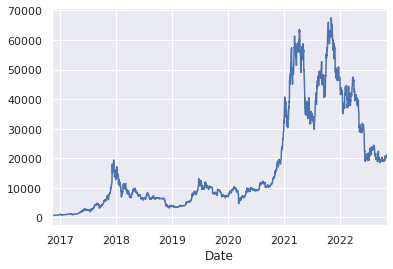

In [7]:
df_cls.plot()

In [8]:
#splitting the dataset
length_df = len(df_cls)
train_fraction = int(0.9 * length_df)
train_df = df_cls[:train_fraction]
val_df = df_cls[train_fraction:]

## Normalize the data
It is important to scale features before training a neural network.One way of scaling the data is through normalization:subtract the mean and divide by standard deviation of each feature.

In [9]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std

## Windowing
When dealing with time series data,the input features are generally represented as a 3D arrays of shape [batch size,time steps,dimensionality],where in our case dimensionality is 1 since we are dealing with univariate time series.
Let's create a function that returns a dataset with that shape.

In [10]:
def windowsGenerator(dataset,window_size,shift=1,batch_size=32):
    """Generates data windows of a given window size"""
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.window(window_size+1,shift=shift,drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.map(lambda window: (tf.reshape(window[:-1],[window_size,1]),window[-1:]))
    return dataset.batch(batch_size).prefetch(1)

In [11]:
train_ds = windowsGenerator(train_df,50,shift=1)
val_ds = windowsGenerator(val_df,50,shift=1)
for X,y in train_ds.take(1):
    print("input_shape: ",X.numpy().shape)
    print("target_shape: ",y.numpy().shape)
   

input_shape:  (32, 50, 1)
target_shape:  (32, 1)


## Baseline metrics
Before using RNNs,it is often a good idea to have a few baseline metrics,or else we may end up thinking that our model works great when in fact it is doing worse than basic models.Let's just use a simple Linear Regression so that each prediction is a linear combination of the values in time series.A Dense layer with no activation set is a linear model.

In [12]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(1)
])

In [13]:
model.compile(loss='mse',optimizer=keras.optimizers.Adam(learning_rate=0.1),metrics=[keras.metrics.MeanAbsoluteError()])
model.fit(train_ds,epochs=20)

Epoch 1/20
61/61 [==============================] - 2s 15ms/step - loss: 0.6964 - mean_absolute_error: 0.6641
Epoch 2/20
61/61 [==============================] - 0s 5ms/step - loss: 0.2229 - mean_absolute_error: 0.3551
Epoch 3/20
61/61 [==============================] - 0s 5ms/step - loss: 0.0672 - mean_absolute_error: 0.1954
Epoch 4/20
61/61 [==============================] - 0s 5ms/step - loss: 0.1829 - mean_absolute_error: 0.3356
Epoch 5/20
61/61 [==============================] - 0s 5ms/step - loss: 0.4915 - mean_absolute_error: 0.5315
Epoch 6/20
61/61 [==============================] - 0s 5ms/step - loss: 0.3045 - mean_absolute_error: 0.3980
Epoch 7/20
61/61 [==============================] - 0s 5ms/step - loss: 0.2957 - mean_absolute_error: 0.4140
Epoch 8/20
61/61 [==============================] - 0s 6ms/step - loss: 0.3232 - mean_absolute_error: 0.4330
Epoch 9/20
61/61 [==============================] - 0s 5ms/step - loss: 0.4061 - mean_absolute_error: 0.4862
Epoch 10/20
61/61 

In [14]:
model.evaluate(val_ds)

6/6 [==============================] - 0s 8ms/step - loss: 7.0972e-04 - mean_absolute_error: 0.0202


[0.000709722691681236, 0.02024652250111103]

The linear regression model achieves a mean absolute error of 0.0202.Let's now build an LSTM model:

In [15]:
#lstm model
model = keras.models.Sequential([
    keras.layers.LSTM(20,return_sequences=True,input_shape=[None,1]),
    keras.layers.LSTM(20,return_sequences=False),
    keras.layers.Dense(1)
])

In [16]:
model.compile(loss='mse',optimizer=keras.optimizers.Adam(learning_rate=0.01),
              metrics=[keras.metrics.MeanAbsoluteError()])
history = model.fit(train_ds,epochs=20)

Epoch 1/20
61/61 [==============================] - 7s 54ms/step - loss: 0.1202 - mean_absolute_error: 0.2366
Epoch 2/20
61/61 [==============================] - 3s 55ms/step - loss: 0.2532 - mean_absolute_error: 0.3558
Epoch 3/20
61/61 [==============================] - 3s 56ms/step - loss: 0.1602 - mean_absolute_error: 0.2491
Epoch 4/20
61/61 [==============================] - 3s 56ms/step - loss: 0.1512 - mean_absolute_error: 0.2730
Epoch 5/20
61/61 [==============================] - 4s 58ms/step - loss: 0.1395 - mean_absolute_error: 0.2416
Epoch 6/20
61/61 [==============================] - 4s 61ms/step - loss: 0.0623 - mean_absolute_error: 0.1690
Epoch 7/20
61/61 [==============================] - 4s 57ms/step - loss: 0.0644 - mean_absolute_error: 0.1702
Epoch 8/20
61/61 [==============================] - 4s 58ms/step - loss: 0.0767 - mean_absolute_error: 0.1825
Epoch 9/20
61/61 [==============================] - 4s 59ms/step - loss: 0.1336 - mean_absolute_error: 0.2671
Epoch 10/2

In [17]:
eval_ = model.evaluate(val_ds)

6/6 [==============================] - 1s 18ms/step - loss: 1.6735e-04 - mean_absolute_error: 0.0125


Our model achieves a mean absolute error of 0.0125 beating the linear regression model.